ENSAE 2018

Quentin Spalla - MS DS

Module : Stochastic Optimization and Automatic Differentiation for Machine Learning

Sujet : Incremental methods with second order information

# Introduction

"Tracking the gradients using the Hessian: A new look at variance reducing stochastic methods" est un article publié en 2017 par  Robert M. Gower, Nicolas Le Roux et Francis Bach.
Les auteurs y présentent de récentes avancées en ce qui concerne les méthodes stochastiques de réduction de variance utilisant la matrice hessienne et ses algorithmes comme le SVRG2, Curvature Matching ou l'Action Matching. 

Dans le cadre de notre projet, nous nous concentrons sur l’implémentation de trois algorithmes de réduction de variance. Nous allons les définir, expliquer leur implémentation et présenter
les résultats obtenus en les comparant à l'algorithme SVRG simple.


# Méthodes stochastiques de réduction de variance

Le principe des méthodes stochastiques de réduction de variance est d'utiliser la connaissance du gradient sur l'ensemble des points. L'article utilise comme benchmark à son travail la méthode SVRG, tous les autres algorithmes sont des extensions de ce dernier. Pour ce travail nous allons nous intéresser à trois de ces extensions : SVRG2, CM et AM.

Tout d'abord, SVRG utilise une technique simple de réduction de variance : la variable de contrôle. L'idée est simplement d'estimer l'espérance $\bar{x}$ d'une variable aléatoire $x$. Pour cela on introduit la variable de contrôle $z$ (d'éspérance $\bar{z}$), on a alors : 
$$x_z= x - z + \bar{z}$$

Son éspérance vaut alors :
\begin{align}
E(x_z) & = E(x - z + \bar{z}) \\
E(x_z) & = E(x) - E(z) + E(\bar{z}) \\
E(x_z) & = \bar{x} - \bar{z} + \bar{z} \\
E(x_z) & = \bar{x}
\end{align}

Et la variance vaut :
\begin{align}
V(x_z) & = V(x - z + \bar{z}) \\
V(x_z) & = V(x) + V(z) - 2Cov(x,z) > V(x) \text{ si } 2Cov(x,z) > V(z) 
\end{align}

C'est cette technique qui est derrière SVRG et c'est également celle utilisée dans les extensions en étant appliquée avec la matrice hessienne.
Dans SVRG, la variable de contrôle $z$ est le gradient obtenu pour les poids moyens de l'ensemble de l'échantillon, autrement dit : $z_i(\theta) = g_i(\bar{\theta})$ avec i le ième échantillon, $\bar{\theta}$ les derniers poids utilisés avant la mise à jour du gradient et $\theta$ les poids actuels.


La descente de gradient va alors se faire comme ceci :
$$\theta_{t+1} = \theta_t - \nu(g_i(\theta) - g_i(\bar{\theta})+g(\bar{\theta}))$$
avec $\nu$ le learning rate.


Pour la méthode SVRG2, on va utiliser la variable de contrôle $z_i(\theta) = g_i(\bar{\theta}) + H_i(\bar{\theta})(\theta-\bar{\theta})$ où $H_i$ est la matrice hessienne du ième échantillon. C'est en développant simplement à l'ordre 2 la formule de Taylor pour le gradient stochastique que l'on utilise cette matrice hessienne. Cela va permettre d'accélerer la convergence mais surtout de faire des pas de gradient plus précis.
On obtient alors la mise à jour du gradient par $$\theta_{t+1} = \theta_t - \nu(g_i(\theta) - g_i(\bar{\theta})- H_i(\bar{\theta})(\theta-\bar{\theta})+g(\bar{\theta}) + H(\bar{\theta})(\theta-\bar{\theta}))$$


L'inconvénient principal de cette méthode est son coût computaionnel. En effet, la matrice carrée hessienne est de taille $d$. Donc les $d^2$ calculs à faire pour l'obtenir coûtent chers quand $d$ commence à être élevé. De plus stocker une matrice de grande taille est coûteux en RAM.


La solution au problème est proposée dans l'article en utilisant l'approximation de la matrice hessienne. Les auteurs proposent par exemple de n'utiliser que la diagonale de la matrice (d calculs au lieu de $\frac{d^2}{2}$) ou bien de diminuer le rang de l'hessienne.

Nous nous intéressont à la seconde technique qui propose deux versions assez similaires : la Curvature Matching et l'Action Matching.
Les deux versions se basent sur une matrice $S \in \mathbb{R}^{d*k}$ (avec $k<<d$) qui va permettre de diminuer le rang de l'hessienne.
La version Curvature Matching cherche à résoudre le modèle : 
\begin{align}
\hat{H_i} & = \underset{X \in \mathbb{R}^{d*d}}{\operatorname{argmin}} \lvert \lvert X \lvert \lvert^2_{F(H)}   \\
\text{ subject to } & S^TXS = S^TH_iS
\end{align}

La matrice hessienne approximée, solution du modèle ci-dessus s'écrit :
$$\hat{H_i}  = HS(S^THS)^{-1}S^TH_iS(S^THS)^{-1}S^TH $$


C'est cette approximation qui est utilisée dans la descente de gradient et qui permet de simplifier computationnellement. On a alors :
$$\theta_{t+1} = \theta_t - \nu(g_i(\theta) - g_i(\bar{\theta})+g(\bar{\theta}) - \bar{A}\bar{S}^TH_i(\bar{\theta})\bar{S}\bar{A}^T(\theta-\bar{\theta}) +\bar{A}\bar{A}^T(\theta-\bar{\theta}))$$

En stockant facilement $C=(S^TA)^{\frac{-1}{2}} \in \mathbb{R}^{k*k}$, $\bar{A}=HSC \in \mathbb{R}^{d*k}$, et $\bar{S}=SC \in \mathbb{R}^{d*k}$ le calcul d'un pas de gradient est bien moins coûteux qu'avec SVRG2.

La matrice S qui permet de faire baisser le rang peut être choisie aléatoirement ou bien en moyennant plusieurs des précédents gradients calculés. Chacune des k colonnes de la matrice S est la moyenne de $\frac{T}{k}$ précédents gradients avec T le nombre de pas de gradients effectués entre chaque mis à jour complète des gradients.


Enfin l'Action Matching est similaire à la Curvature Matching à cela près qu'elle résoud le modèle : 
\begin{align}
\hat{H_i} & = \underset{X \in \mathbb{R}^{d*d}}{\operatorname{argmin}} \lvert \lvert X \lvert \lvert^2_{F(H)}   \\
\text{ subject to } & XS = H_iS \text{ and } X = X^T
\end{align}

La matrice hessienne approximée, solution du modèle ci-dessus s'écrit :
$$\hat{H_i}  = HS(S^THS)^{-1}S^TH_i(I-S(S^THS)^{-1}S^TH) + H_iS(S^THS)^{-1}S^TH $$


C'est cette approximation qui est utilisée dans la descente de gradient et qui permet de simplifier computationnellement. On a alors :
$$\theta_{t+1} = \theta_t - \nu(g_i(\theta) - g_i(\bar{\theta})+g(\bar{\theta}) - (\bar{A}\bar{S}^TH_i(I -\bar{S}\bar{A}^T) +H_i\bar{S}\bar{A}^T)(\theta-\bar{\theta}) +\bar{A}\bar{A}^T(\theta-\bar{\theta}))$$

# Implémentation

Le code a été intégralement codé en Python, il est disponible sur ce GitHub : https://github.com/QuentinSpalla/sto_opt_svrg.

Les librairies utilisées sont matplotlib.pyplot, numpy, math, scipy.linalg et datetime.

Pour simplifier le projet, il a été divisé en plusieurs fichiers, cela permet notamment une généralisation plus facile pour adapter le code à des problèmes différents. Présentons les fichiers :

- get_data.py est le fichier qui permet de créer la matrice de données ainsi que la variable à expliquer. Il contient la classe AllData qui va permettre de récupérer le fichier de données dont on a besoin. Ses principaux attributs sont A, qui est la matrice des variables explicatives et b qui est le vecteur de la variable à expliquer. Dans notre cas, nous choisissons un problème simple car nous nous intéressons surtout aux algorithmes et leur efficience, nous ne cherchons pas ici à résoudre un véritable problème à l'aide du machine learning. Mais la classe a été généralisée si jamais on avait besoin de le faire.


- gradient_tool.py est le fichier regroupant l'ensemble des fonctions utiles pour faire la descente de gradient de nos algorithmes. Des fonctions comme grad(), partial_grad(), hess() et hess_partial() permettent d'obtenir les dérivées premières et secondes.


- svrm.py est le fichier principal qui regroupe quatre classes : SVRG, SVRG2, CM et AM. Chacune a été codée de manière similaire avec comme unique méthode : train(). C'est la méthode qui va faire la descente de gradient en suivant les pseudo-codes disponibles dans l'article. Cette partie du code n'a pas besoin d'être modifiée si l'on veut résoudre un nouveau problème. Il suffit simplement de changer les fonctions de calcul des dérivées dans le fichier gradient_tool.py (si on change la fonction de perte bien entendu) et le fichier get_data.py pour obtenir un nouveau jeu de données.


- main.ipynb est le jupyter notebook qui a permis de créer ce pdf (il n'y a donc rien de plus que dans ce document). Il appelle les fichiers précédents.

# Expériences

## Algorithmes

Comme indiqué plus haut, nous allons tester les algorithmes SVRG2, CM et AM que nous allons comparer à la méthode classique SVRG. 

Ici nous résolvons un problème simple, une régression logistique. Nous nous inspirons des TP vus en cours pour simuler des données ainsi que la variable à expliquer (fichier get_data.py). Un problème simple comme celui-ci va nous permettre d'éviter tout biais potentiels d'un jeu de données réel, nous pourrons donc observer le comportement de chaque algorithme pour la résolution d'un problème élémentaire. Il serait possible de complexifier dans un second temps.


Nous avons donc une fonction de perte qui vaut :

$$L_{\theta}(x) = -log(h_{\theta}(x)) \text{ avec } h_{\theta}(x) = \frac{1}{1+e^{-\theta^Tx}}$$

Nous voulons à présent calculer le gradient :
\begin{align}
\frac{\delta{L_{\theta}(x)}}{\delta{\theta}}& = \nabla _\theta [- \log( h_\theta ( x))] \\
& = \nabla_\theta [log ( 1+e^{-\theta^Tx})] \\ 
& = ( {\frac{-e^{-\theta^Tx}}{1 + e^{-\theta^Tx}} }) x \\ 
& = ( {\frac{1}{1 + e^{-\theta^Tx}} - 1}) x \\ 
& = ( {h_\theta( x ) - 1})x
\end{align}

et également la dérivée d'ordre 2 :
\begin{align} 
\frac{\delta^2{L_{\theta}(x)}}{\delta{\theta^2}}
& = \nabla _\theta^2  [ { - \log ( {{h_\theta }(x)} )}] \\
& = \nabla _\theta ( \nabla _\theta [ { - \log ( {{h_\theta }( x )} )} ] ) \\ 
& =  \nabla _\theta ( ( {h_\theta( x ) - 1}) x ) \\ 
& =  h_\theta( x ) ( 1 - h_\theta( x ) ) xx^T 
\end{align}


Grâce à ces formules simples à coder, nous pouvons tester les différentes méthodes et observer les résultats.

## Résultats

Nous commencons par créer deux fonctions qui seront utiles pour présenter les résultats.


La première est create_all_loss_history() qui permet de créer le jeu de données sur lequel travailler puis de faire tourner les différentes méthodes de réduction de variance sur ce jeu de données pour observer leur capacité à minimiser la perte.


La seconde est plot_all_loss_history() qui va affichier quatre graphiques. Un, la fonction de sous-optimalité en fonction du nombre d'époques, un autre en fonction du temps, un autre la fonction de perte en fonction du nombre d'époques et le dernier en fonction du temps.  Avoir ces quatre visualisations va nous permettre de comprendre les caractéristiques des algorithmes. Par exemple on sait déjà que SVRG2 aura tendance à être moins bon en temps car il lui faut calculer entièrement la matrice hessienne.


In [1]:
from get_data import AllData
from svrm import SVRG, CM, SVRG2, AM
import matplotlib.pyplot as plt
import tools
import numpy as np
np.random.seed(1234)

def create_all_history(nbr_epoch, nbr_updates, time_in_seconds, nbr_features, nbr_samples, rank_s, is_datapass):
    all_data = AllData(nbr_samples, nbr_features)
    learning_rate = 1. / (max(np.sum(all_data.A, 1)) / (4*nbr_samples) + max(np.sum(all_data.A, 1)))
    my_svrg = SVRG(all_data.A, all_data.b, nbr_epoch, nbr_updates, learning_rate, time_in_seconds)
    my_cm = CM(all_data.A, all_data.b, nbr_epoch, nbr_updates, learning_rate, rank_s, time_in_seconds)
    my_svrg2 = SVRG2(all_data.A, all_data.b, nbr_epoch, nbr_updates, learning_rate, time_in_seconds)
    my_am = AM(all_data.A, all_data.b, nbr_epoch, nbr_updates, learning_rate, rank_s, time_in_seconds)
    my_svrg.train(is_datapass)
    my_cm.train(is_datapass)
    my_svrg2.train(is_datapass)
    my_am.train(is_datapass)
    #return my_svrg.loss_history, my_cm.loss_history, my_svrg2.loss_history, my_am.loss_history
    return (my_svrg.grad_history, my_cm.grad_history, my_svrg2.grad_history, my_am.grad_history, 
            my_svrg.loss_history, my_cm.loss_history, my_svrg2.loss_history, my_am.loss_history)

def plot_all_history(svrg_grad_d, svrg_grad_t, svrg2_grad_d, svrg2_grad_t, cm_grad_d, cm_grad_t, am_grad_d, am_grad_t, 
                     svrg_loss_d, svrg_loss_t, svrg2_loss_d, svrg2_loss_t, cm_loss_d, cm_loss_t, am_loss_d, am_loss_t):
    plt.figure(figsize=(20,15))
    
    max_size = max(len(svrg_grad_t), len(svrg2_grad_t), len(cm_grad_t), len(am_grad_t))
    svrg_grad_t = tools.increase_size_list(svrg_grad_t, max_size)
    svrg2_grad_t = tools.increase_size_list(svrg2_grad_t, max_size)
    cm_grad_t = tools.increase_size_list(cm_grad_t, max_size)
    am_grad_t = tools.increase_size_list(am_grad_t, max_size)
    svrg_loss_t = tools.increase_size_list(svrg_loss_t, max_size)
    svrg2_loss_t = tools.increase_size_list(svrg2_loss_t, max_size)
    cm_loss_t = tools.increase_size_list(cm_loss_t, max_size)
    am_loss_t = tools.increase_size_list(am_loss_t, max_size)
    
    plt.figure(1)
    plt.subplot(221)
    plt.plot(svrg_grad_d, '--', lw=3, label='SVRG')
    plt.plot(cm_grad_d, '-', lw=3, label='CM')
    plt.plot(am_grad_d, '-.', lw=3, label='AM')
    plt.plot(svrg2_grad_d, ':', lw=3, label='SVRG2')
    plt.grid()
    plt.legend()
    plt.yscale('log')
    plt.ylabel('Function suboptimality')
    plt.xlabel('Nbr Epochs')
    
    plt.subplot(222)
    plt.plot(svrg_loss_d,'--', lw=3, label='SVRG')
    plt.plot(cm_loss_d,'-', lw=3, label='CM')
    plt.plot(am_loss_d,'-.', lw=3, label='AM')
    plt.plot(svrg2_loss_d,':', lw=3, label='SVRG2')
    plt.grid()
    plt.legend()
    plt.yscale('log')
    plt.ylabel('Function loss')
    plt.xlabel('Nbr Epochs')
    
    plt.subplot(223)
    plt.plot(svrg_grad_t,'--', lw=3, label='SVRG')
    plt.plot(cm_grad_t,'-', lw=3, label='CM')
    plt.plot(am_grad_t,'-.', lw=3, label='AM')
    plt.plot(svrg2_grad_t,':', lw=3, label='SVRG2')
    plt.grid()
    plt.legend()
    plt.yscale('log')
    plt.ylabel('Function suboptimality')
    plt.xlabel('Time')                
    
    plt.subplot(224)
    plt.plot(svrg_loss_t,'--', lw=3, label='SVRG')
    plt.plot(cm_loss_t,'-', lw=3, label='CM')
    plt.plot(am_loss_t,'-.', lw=3, label='AM')
    plt.plot(svrg2_loss_t,':', lw=3, label='SVRG2')
    plt.grid()
    plt.legend()
    plt.yscale('log')
    plt.ylabel('Function loss')
    plt.xlabel('Time')
    
    plt.show()

Nous allons procéder à plusieurs tests en faisant varier les paramètres. Nous visualiserons ainsi des comportements différents selon ces paramètres.
Définissons rapidement ces paramètres :

- nbr_features est le nombre de paramètres de notre jeu de données. Nous évitons d'en choisir un trop gros pour que les calculs de matrice hessiennes ne soient pas trop longs. Il correspond au d dans l'article.


- nbr_samples est le nombre d'échantillons de notre jeu de données. Il correspond au N dans l'article.


- nbr_updates est le nombre de pas de gradient avant de faire la mise à jour sur la totalité du jeu de données. Il correspond au T dans l'article et est multiple de N.


- nbr_epoch est le nombre total d'itérations. Si on le divise par par T alors on obtient le nombre d'époques, c'est-à-dire le nombre de mise à jour générale sur la totalité du jeu de données.


- time_in_seconds est utilisé pour fixer un temps limite à l'algorithme pour s'effectuer. On pourra ainsi comparer les différentes méthodes en fonction du temps.


- rank_s est équivalent au k dans l'article. Il est utilisé dans les méthodes CM et AM pour baisser le rang de la matrice hessienne. Nous choisissons $k=10$ comme dans l'article.


Pour information, nous faisons comme dans l'article pour le calcul du learning rate. A savoir nous le choisissons de l'ordre de : $\frac{1}{L_{max}}$, avec $L_{max}=\underset{i=1,...,N}{\operatorname{max}} \lvert \lvert x_i \lvert \lvert^2_2  (1+\frac{1}{4N})$ 

Commencons avec un nombre de features faible, ici $d=50$. On pose également $T=N=100$. Nous voulons observer 100 époques et environ 10 secondes de minimisation.

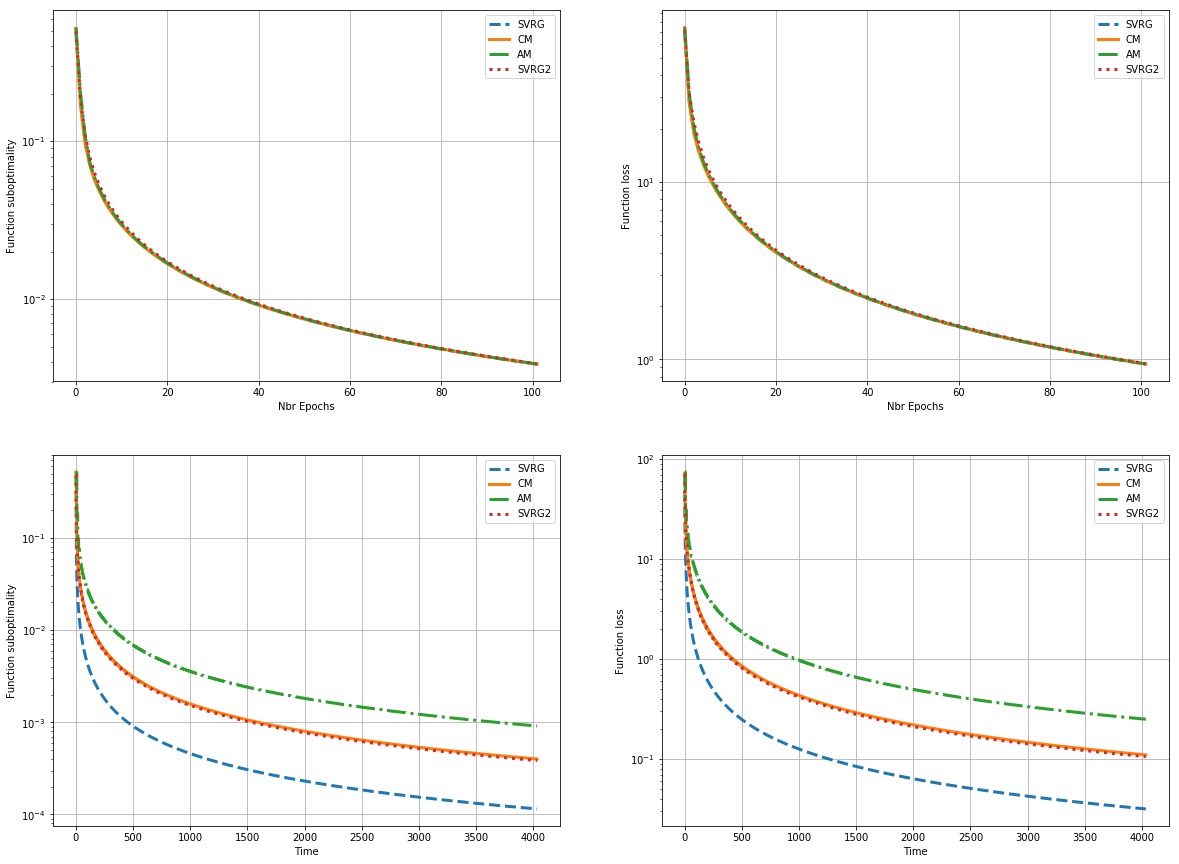

In [12]:
nbr_epoch = 10000
nbr_updates = 100
time_in_seconds = 10
nbr_features = 50
nbr_samples = 100
rank_s = 10

is_datapass = True
(svrg_grad_d, cm_grad_d, svrg2_grad_d, am_grad_d, 
 svrg_loss_d, cm_loss_d, svrg2_loss_d, am_loss_d) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
is_datapass = False
(svrg_grad_t, cm_grad_t, svrg2_grad_t, am_grad_t, 
 svrg_loss_t, cm_loss_t, svrg2_loss_t, am_loss_t) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
plot_all_history(svrg_grad_d, svrg_grad_t, svrg2_grad_d, svrg2_grad_t, cm_grad_d, cm_grad_t, am_grad_d, am_grad_t, 
                 svrg_loss_d, svrg_loss_t, svrg2_loss_d, svrg2_loss_t, cm_loss_d, cm_loss_t, am_loss_d, am_loss_t)

On observe bien qu'en fonction du nombre d'époques, les quatre algorithmes se confondent et suivent la même trajectoire à la fois pour la fonction de sous-optimalité et pour la fonction de perte. A l'inverse en étudiant les graphiques en fonction du temps, on voit que SVRG converge plus vite que les autres. SVRG2 et CM sont confondus tandis qu'AM converge moins vite. 

Il convient de préciser maintenant que l'ensemble des résultats obtenus pour AM en fonction du temps ne sont pas bon. Cet algorithme est présenté comme convergent très rapidement dans l'article, mais dans nos expériences, c'est celui allant le plus lentement. Cela est sans doute dû à la structure du code qui n'est pas optimale. Nous parlerons donc surtout de la méthode AM en fonction du nombre d'époques mais pas en fonction du temps.

Commencons avec un nombre de features faible, ici $d=50$. On pose également $T=N=1000$

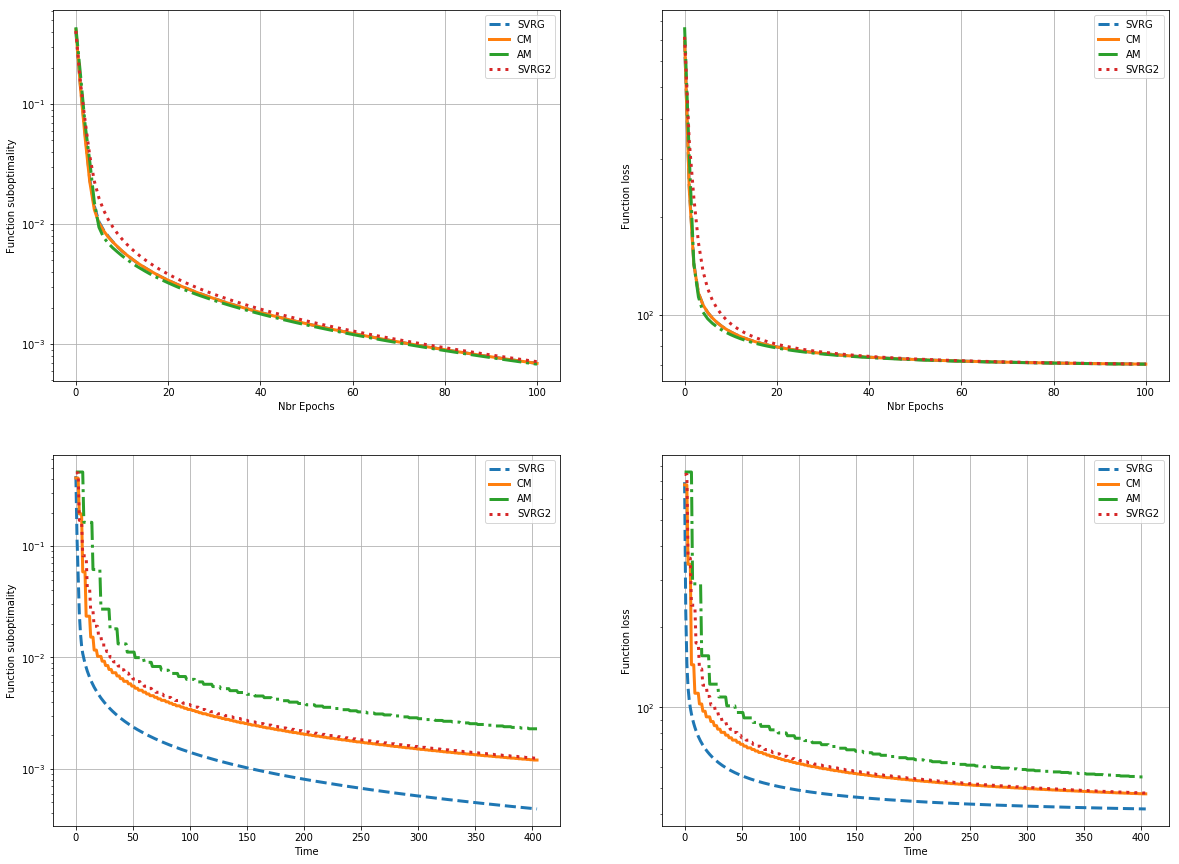

In [13]:
nbr_epoch = 100000
nbr_updates = 1000
time_in_seconds = 10
nbr_features = 50
nbr_samples = 1000
rank_s = 10

is_datapass = True
(svrg_grad_d, cm_grad_d, svrg2_grad_d, am_grad_d, 
 svrg_loss_d, cm_loss_d, svrg2_loss_d, am_loss_d) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
is_datapass = False
(svrg_grad_t, cm_grad_t, svrg2_grad_t, am_grad_t, 
 svrg_loss_t, cm_loss_t, svrg2_loss_t, am_loss_t) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
plot_all_history(svrg_grad_d, svrg_grad_t, svrg2_grad_d, svrg2_grad_t, cm_grad_d, cm_grad_t, am_grad_d, am_grad_t, 
                 svrg_loss_d, svrg_loss_t, svrg2_loss_d, svrg2_loss_t, cm_loss_d, cm_loss_t, am_loss_d, am_loss_t)

Essayons à présent d'augmenter exclusivement le nombre de features ($d=500$). On converve les autres paramètres aux mêmes valeurs.

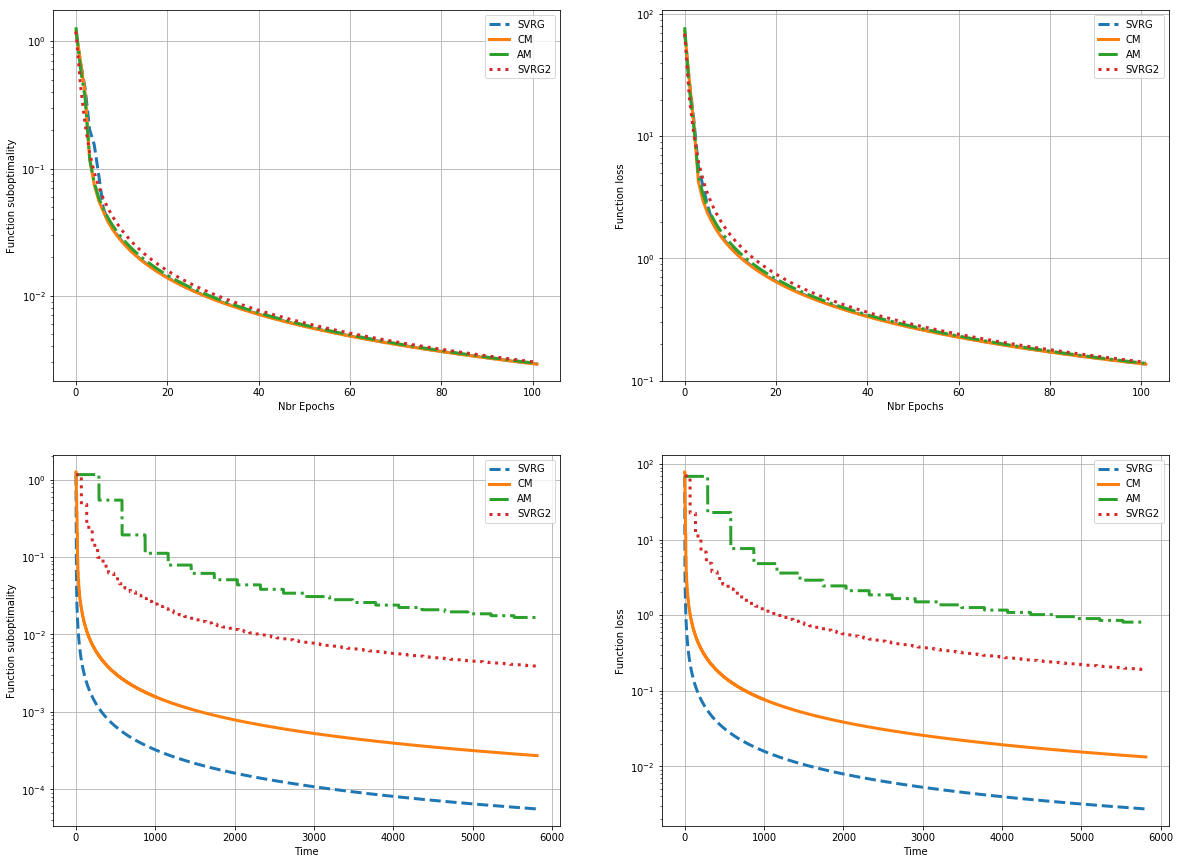

In [14]:
nbr_epoch = 10000
nbr_updates = 100
time_in_seconds = 20
nbr_features = 500
nbr_samples = 100

is_datapass = True
(svrg_grad_d, cm_grad_d, svrg2_grad_d, am_grad_d, 
 svrg_loss_d, cm_loss_d, svrg2_loss_d, am_loss_d) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
is_datapass = False
(svrg_grad_t, cm_grad_t, svrg2_grad_t, am_grad_t, 
 svrg_loss_t, cm_loss_t, svrg2_loss_t, am_loss_t) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
plot_all_history(svrg_grad_d, svrg_grad_t, svrg2_grad_d, svrg2_grad_t, cm_grad_d, cm_grad_t, am_grad_d, am_grad_t, 
                 svrg_loss_d, svrg_loss_t, svrg2_loss_d, svrg2_loss_t, cm_loss_d, cm_loss_t, am_loss_d, am_loss_t)

On voit qu'en fonction du nombre d'époques, la convergence est à nouveau similaire entre les méthodes mais plus aussi exactement. Si on regarde le graphique de la sous-optimalité en fonction du temps, on remarque qu'à nouveau, SVRG converge le plus rapidement. On peut également noter que CM et SVRG2 ne sont plus confondus, CM converge plus rapidement cela est dû à l'approximation de l'hessienne qui permet de gagner en temps de calcul.

Commencons avec un nombre de features faible, ici $d=500$. On pose également $T=N=1000$

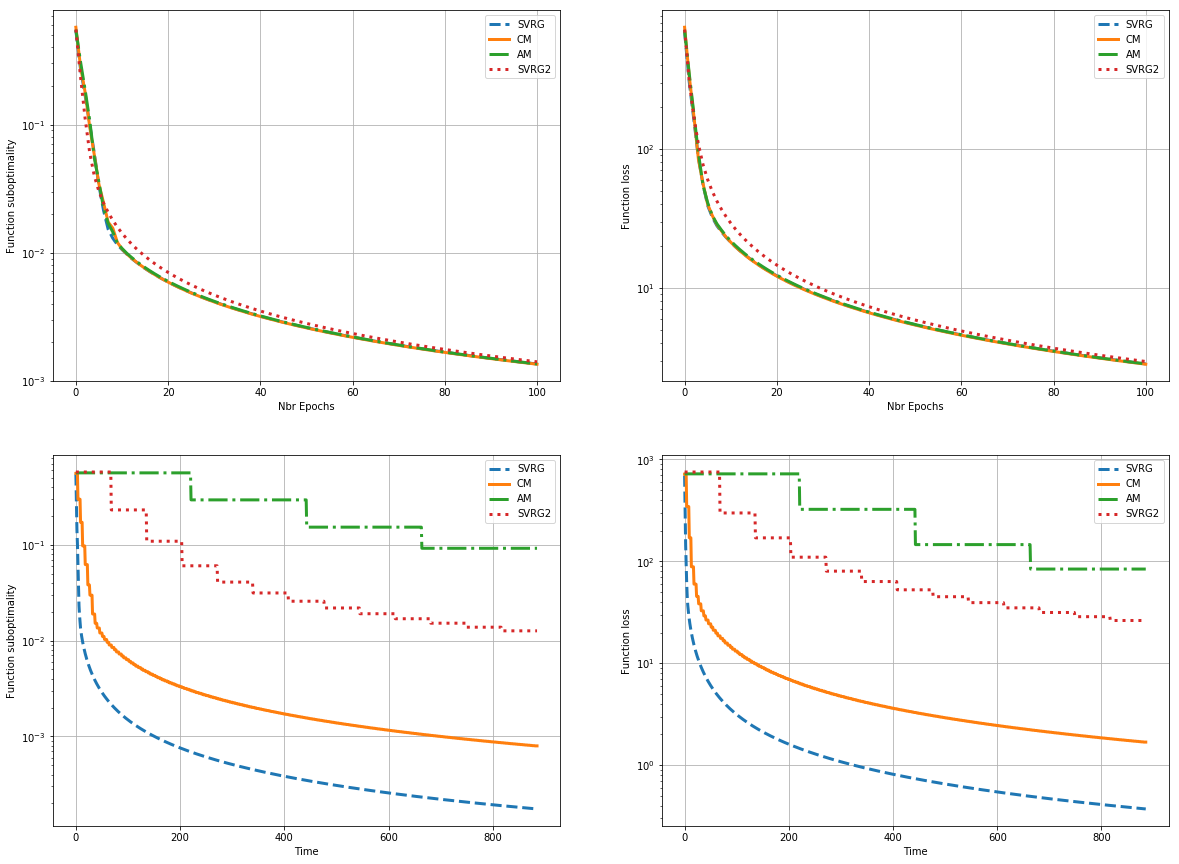

In [15]:
nbr_epoch = 100000
nbr_updates = 1000
time_in_seconds = 30
nbr_features = 500
nbr_samples = 1000
rank_s = 10
is_datapass = True
(svrg_grad_d, cm_grad_d, svrg2_grad_d, am_grad_d, 
 svrg_loss_d, cm_loss_d, svrg2_loss_d, am_loss_d) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
is_datapass = False
(svrg_grad_t, cm_grad_t, svrg2_grad_t, am_grad_t, 
 svrg_loss_t, cm_loss_t, svrg2_loss_t, am_loss_t) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
plot_all_history(svrg_grad_d, svrg_grad_t, svrg2_grad_d, svrg2_grad_t, cm_grad_d, cm_grad_t, am_grad_d, am_grad_t, 
                 svrg_loss_d, svrg_loss_t, svrg2_loss_d, svrg2_loss_t, cm_loss_d, cm_loss_t, am_loss_d, am_loss_t)

Commencons avec un nombre de features faible, ici $d=500$. On pose également $N=1000$ et $T=2000$

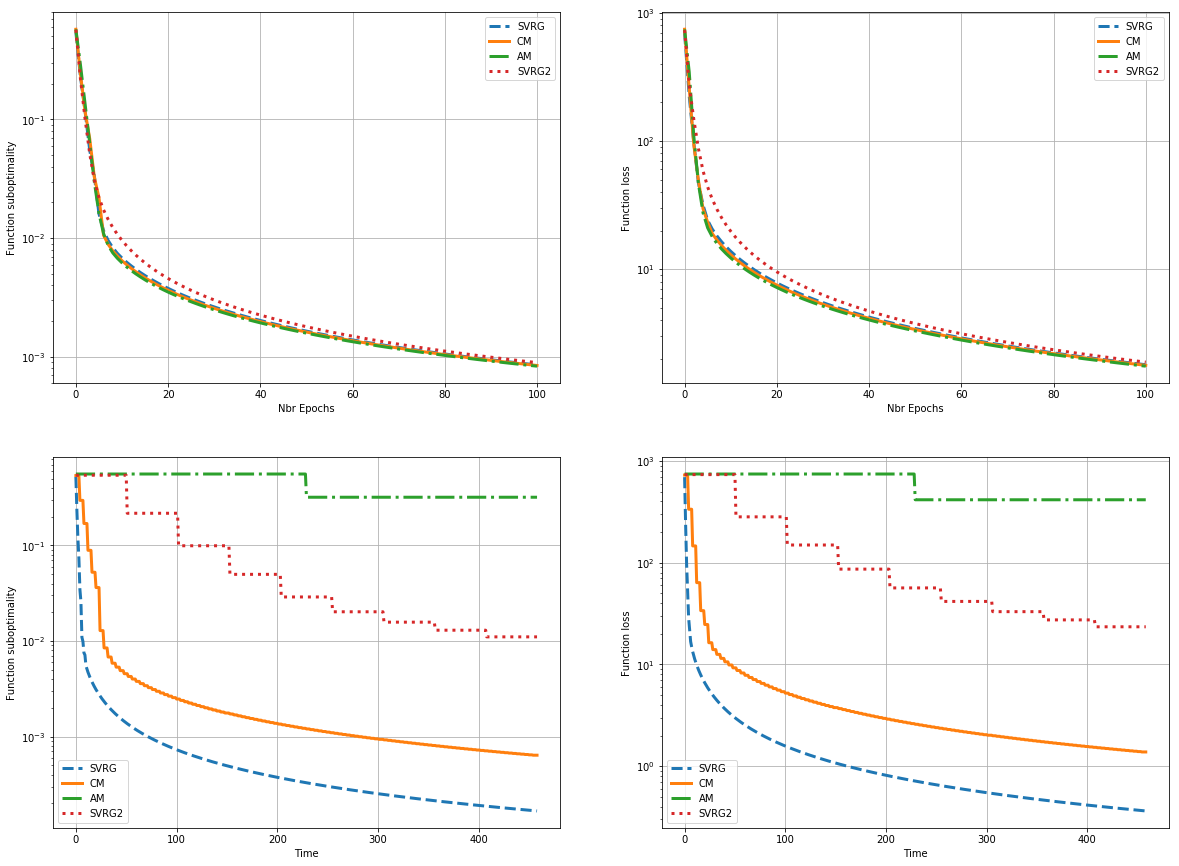

In [16]:
nbr_epoch = 200000
nbr_updates = 2000
time_in_seconds = 30
nbr_features = 500
nbr_samples = 1000
rank_s = 10
is_datapass = True
(svrg_grad_d, cm_grad_d, svrg2_grad_d, am_grad_d, 
 svrg_loss_d, cm_loss_d, svrg2_loss_d, am_loss_d) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
is_datapass = False
(svrg_grad_t, cm_grad_t, svrg2_grad_t, am_grad_t, 
 svrg_loss_t, cm_loss_t, svrg2_loss_t, am_loss_t) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
plot_all_history(svrg_grad_d, svrg_grad_t, svrg2_grad_d, svrg2_grad_t, cm_grad_d, cm_grad_t, am_grad_d, am_grad_t, 
                 svrg_loss_d, svrg_loss_t, svrg2_loss_d, svrg2_loss_t, cm_loss_d, cm_loss_t, am_loss_d, am_loss_t)

Nous essayons à présent un problème de plus grande taille. Nous posons $N=1000$ et $T=5000$ et conservons un nombre de features élevé, $d=500$.

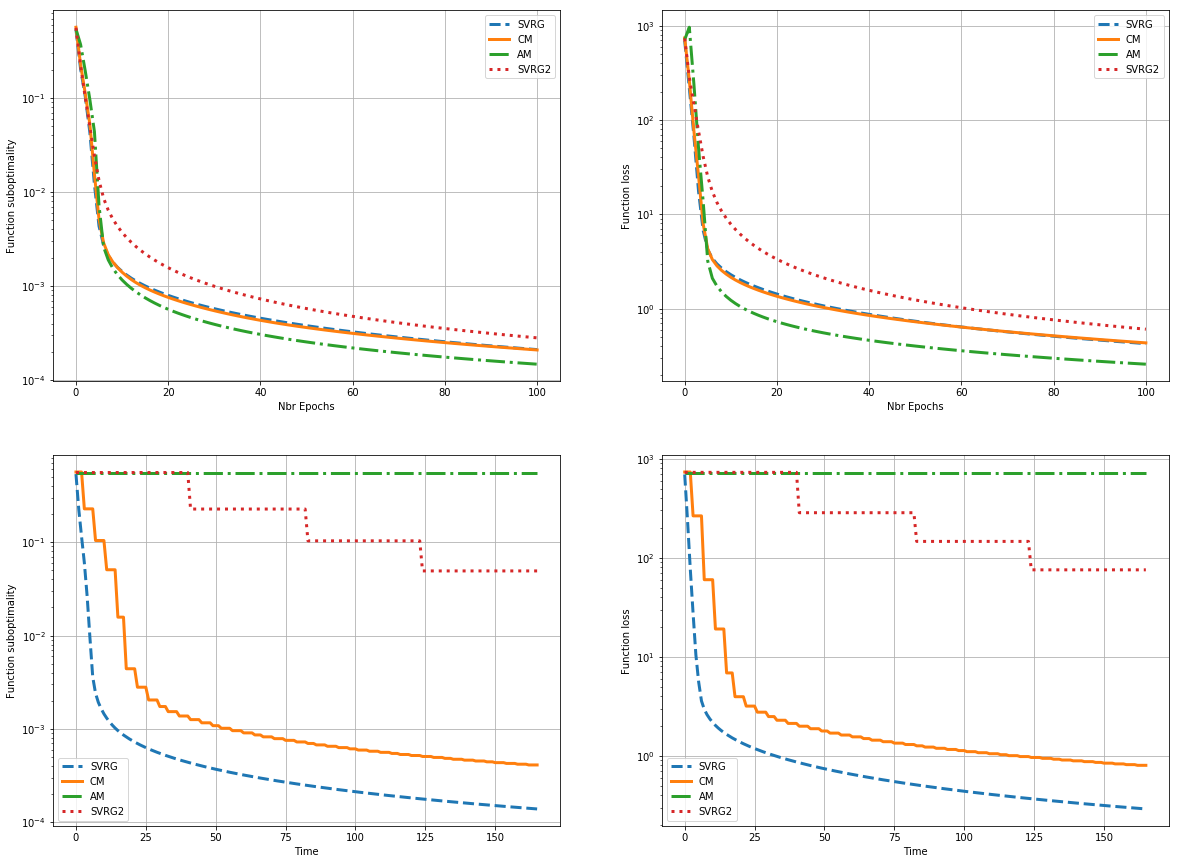

In [17]:
nbr_epoch = 500000
nbr_updates = 5000
time_in_seconds = 30
nbr_features = 500
nbr_samples = 1000
rank_s = 10
is_datapass = True
(svrg_grad_d, cm_grad_d, svrg2_grad_d, am_grad_d, 
 svrg_loss_d, cm_loss_d, svrg2_loss_d, am_loss_d) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
is_datapass = False
(svrg_grad_t, cm_grad_t, svrg2_grad_t, am_grad_t, 
 svrg_loss_t, cm_loss_t, svrg2_loss_t, am_loss_t) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
plot_all_history(svrg_grad_d, svrg_grad_t, svrg2_grad_d, svrg2_grad_t, cm_grad_d, cm_grad_t, am_grad_d, am_grad_t, 
                 svrg_loss_d, svrg_loss_t, svrg2_loss_d, svrg2_loss_t, cm_loss_d, cm_loss_t, am_loss_d, am_loss_t)

On observe qu'avec un T plus grand, la méthode SVRG n'est plus celle qui converge le plus rapidement en fonction du nombre d'époques. On voit nettement que la méthode AM converge plus vite que les autres. Par contre en fonction du temps, la même conclusion nous apparaît, SVRG demeure la méthode la plus rapide.

Commencons avec un nombre de features faible, ici $d=600$. On pose également $N=1000$ et $T=2000$

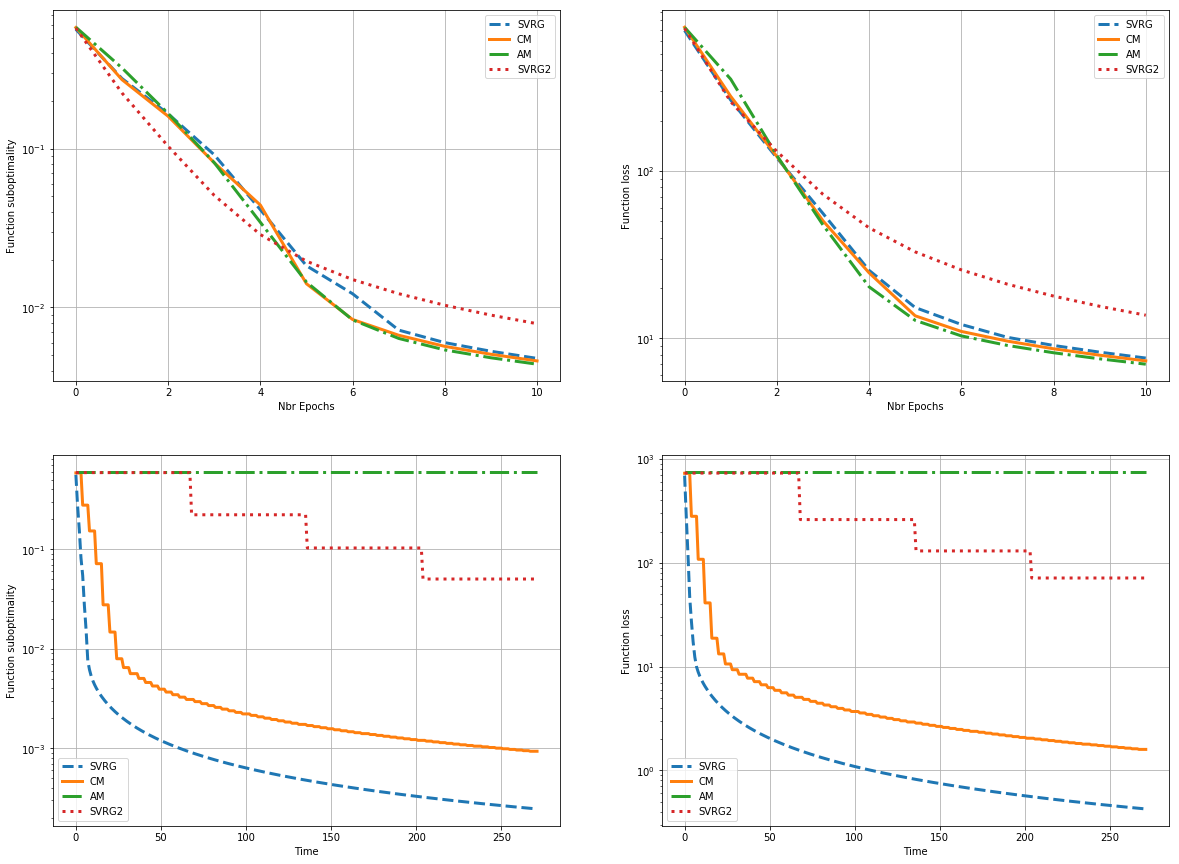

In [18]:
nbr_epoch = 20000
nbr_updates = 2000
time_in_seconds = 20
nbr_features = 600
nbr_samples = 1000
rank_s = 10
is_datapass = True
(svrg_grad_d, cm_grad_d, svrg2_grad_d, am_grad_d, 
 svrg_loss_d, cm_loss_d, svrg2_loss_d, am_loss_d) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
is_datapass = False
(svrg_grad_t, cm_grad_t, svrg2_grad_t, am_grad_t, 
 svrg_loss_t, cm_loss_t, svrg2_loss_t, am_loss_t) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
plot_all_history(svrg_grad_d, svrg_grad_t, svrg2_grad_d, svrg2_grad_t, cm_grad_d, cm_grad_t, am_grad_d, am_grad_t, 
                 svrg_loss_d, svrg_loss_t, svrg2_loss_d, svrg2_loss_t, cm_loss_d, cm_loss_t, am_loss_d, am_loss_t)

A présent nous abaissons le nombre d'époques à 10 pour observer plus précisément le début de la minimisation. On conserve un nombre élevé de features, $d=600$ et posons $T=N=2000$.

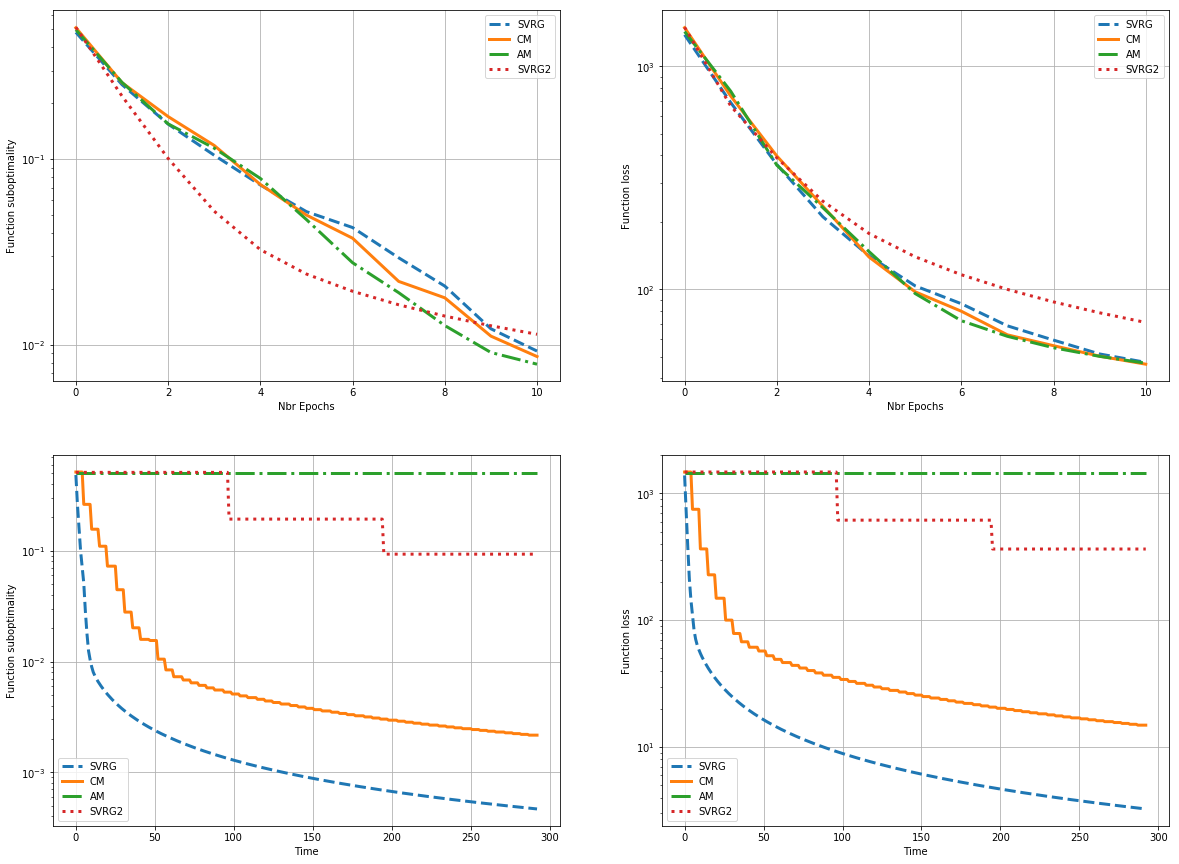

In [19]:
nbr_epoch = 20000
nbr_updates = 2000
time_in_seconds = 20
nbr_features = 600
nbr_samples = 2000
rank_s = 10
is_datapass = True
(svrg_grad_d, cm_grad_d, svrg2_grad_d, am_grad_d, 
 svrg_loss_d, cm_loss_d, svrg2_loss_d, am_loss_d) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
is_datapass = False
(svrg_grad_t, cm_grad_t, svrg2_grad_t, am_grad_t, 
 svrg_loss_t, cm_loss_t, svrg2_loss_t, am_loss_t) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
plot_all_history(svrg_grad_d, svrg_grad_t, svrg2_grad_d, svrg2_grad_t, cm_grad_d, cm_grad_t, am_grad_d, am_grad_t, 
                 svrg_loss_d, svrg_loss_t, svrg2_loss_d, svrg2_loss_t, cm_loss_d, cm_loss_t, am_loss_d, am_loss_t)

On remarque facilement que la méthode SVRG2 converge vite avec ces paramètres avant d'être rattrapée par les autres méthodes. Cela peut être dûe à l'exactitude du calcul de la matrice hessienne. En fonction du temps, la conclusion est la même que précedemment, SVRG2 est encore logiquement la méthode la plus lente (on ne compte pas AM qui est lente à cause du code).

Si on s'intéresse à la fonction de perte, on voit que SVRG, CM et AM converge à une vitesse similaire, par contre SVRG2 est plus lente.

Commencons avec un nombre de features faible, ici $d=600$. On pose également $N=2000$ et $T=2000$

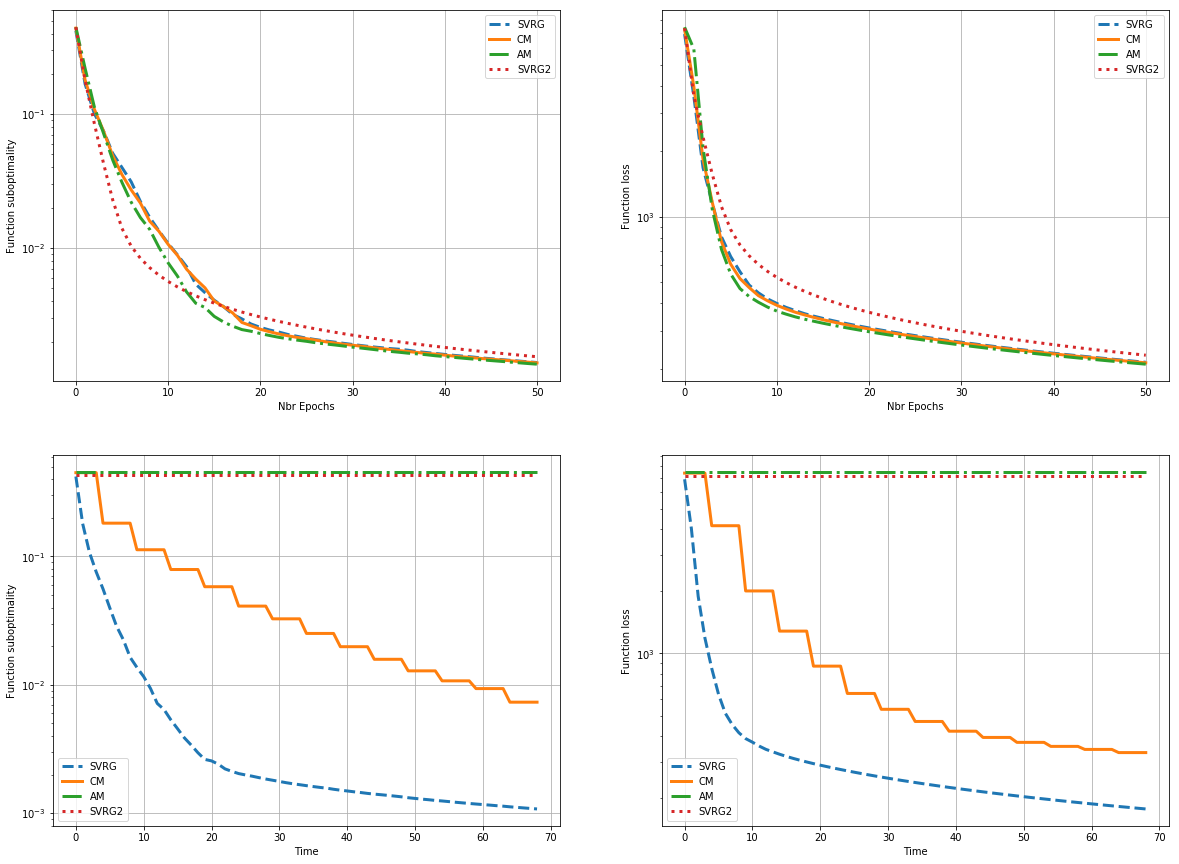

In [2]:
nbr_epoch = 500000
nbr_updates = 10000
time_in_seconds = 20
nbr_features = 600
nbr_samples = 10000
rank_s = 10
is_datapass = True
(svrg_grad_d, cm_grad_d, svrg2_grad_d, am_grad_d, 
 svrg_loss_d, cm_loss_d, svrg2_loss_d, am_loss_d) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
is_datapass = False
(svrg_grad_t, cm_grad_t, svrg2_grad_t, am_grad_t, 
 svrg_loss_t, cm_loss_t, svrg2_loss_t, am_loss_t) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
plot_all_history(svrg_grad_d, svrg_grad_t, svrg2_grad_d, svrg2_grad_t, cm_grad_d, cm_grad_t, am_grad_d, am_grad_t, 
                 svrg_loss_d, svrg_loss_t, svrg2_loss_d, svrg2_loss_t, cm_loss_d, cm_loss_t, am_loss_d, am_loss_t)

Commencons avec un nombre de features faible, ici $d=600$. On pose également $N=5000$ et $T=5000$

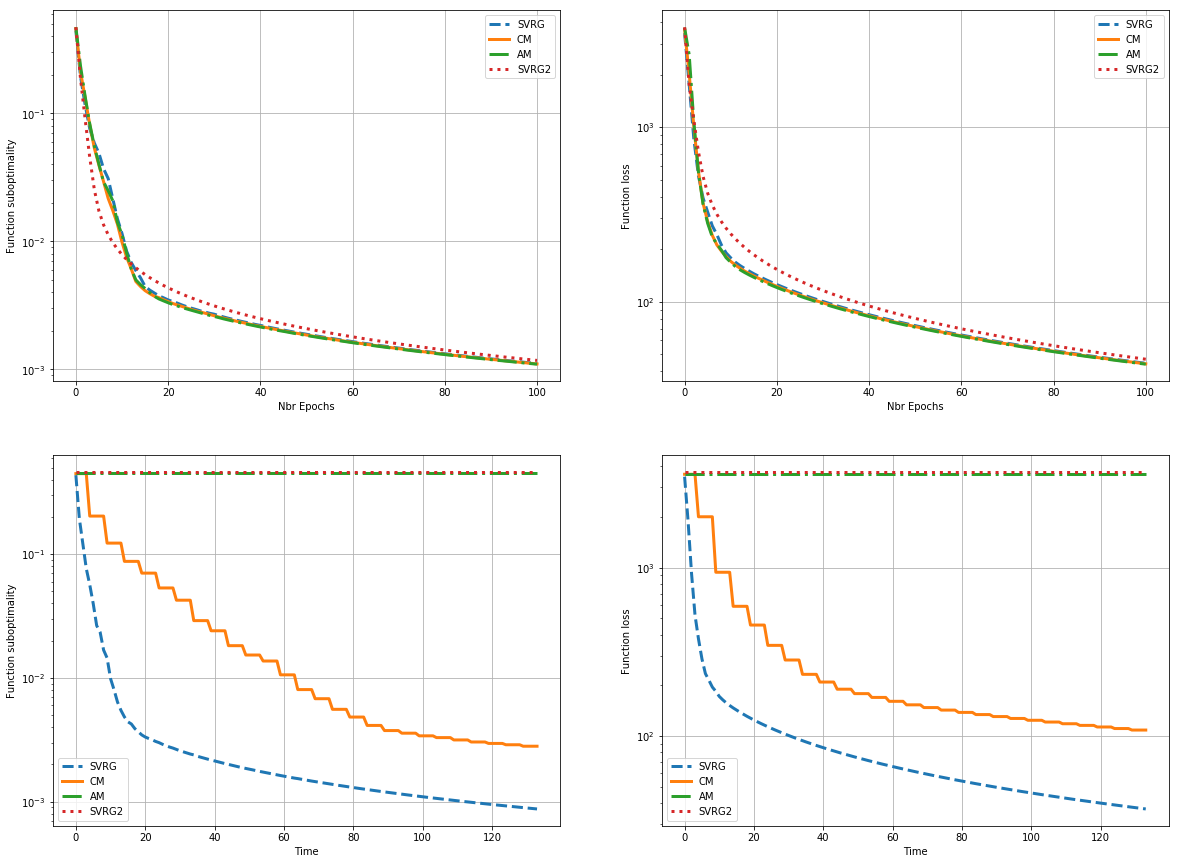

In [3]:
nbr_epoch = 500000
nbr_updates = 5000
time_in_seconds = 20
nbr_features = 600
nbr_samples = 5000
rank_s = 10
is_datapass = True
(svrg_grad_d, cm_grad_d, svrg2_grad_d, am_grad_d, 
 svrg_loss_d, cm_loss_d, svrg2_loss_d, am_loss_d) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
is_datapass = False
(svrg_grad_t, cm_grad_t, svrg2_grad_t, am_grad_t, 
 svrg_loss_t, cm_loss_t, svrg2_loss_t, am_loss_t) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
plot_all_history(svrg_grad_d, svrg_grad_t, svrg2_grad_d, svrg2_grad_t, cm_grad_d, cm_grad_t, am_grad_d, am_grad_t, 
                 svrg_loss_d, svrg_loss_t, svrg2_loss_d, svrg2_loss_t, cm_loss_d, cm_loss_t, am_loss_d, am_loss_t)

Nous essayons également un petit nombre de features, $d=50$, avec un grand jeu de données, $N=5000$ et $T=5000$. 

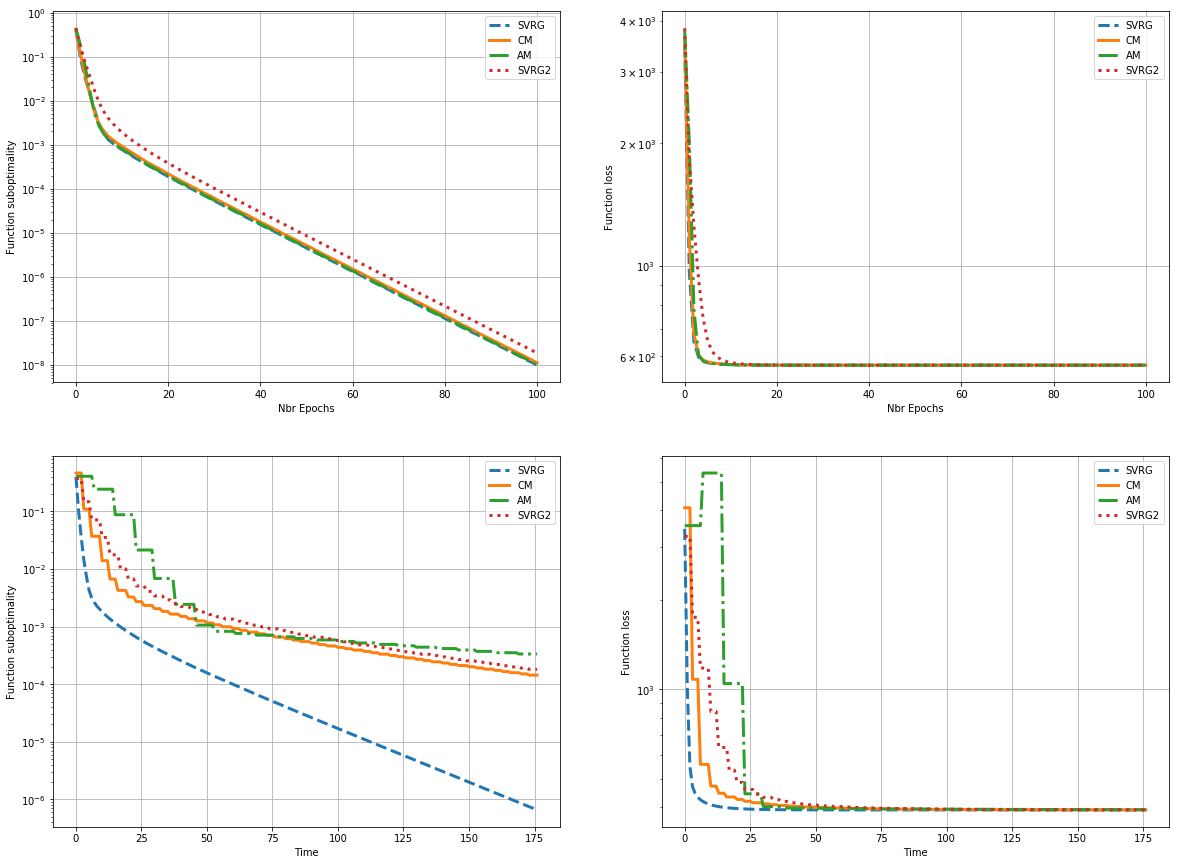

In [4]:
nbr_epoch = 500000
nbr_updates = 5000
time_in_seconds = 20
nbr_features = 50
nbr_samples = 5000
rank_s = 10
is_datapass = True
(svrg_grad_d, cm_grad_d, svrg2_grad_d, am_grad_d, 
 svrg_loss_d, cm_loss_d, svrg2_loss_d, am_loss_d) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
is_datapass = False
(svrg_grad_t, cm_grad_t, svrg2_grad_t, am_grad_t, 
 svrg_loss_t, cm_loss_t, svrg2_loss_t, am_loss_t) = create_all_history(nbr_epoch, nbr_updates, time_in_seconds, 
                                                                       nbr_features, nbr_samples, rank_s, is_datapass)
plot_all_history(svrg_grad_d, svrg_grad_t, svrg2_grad_d, svrg2_grad_t, cm_grad_d, cm_grad_t, am_grad_d, am_grad_t, 
                 svrg_loss_d, svrg_loss_t, svrg2_loss_d, svrg2_loss_t, cm_loss_d, cm_loss_t, am_loss_d, am_loss_t)

On remarque que la convergence est linéaire après un certain nombre d'époques. On observe également que SVRG2 est la méthode qui a convergé légèrement moins vite que les trois autres.

Il est intéressant ici d'observer la convergence en temps. On voit très nettement que la méthode SVRG converge plus vite que les autres. On voit en effet que le coefficient de sa pente est plus important que pour les trois autres méthodes.

# Conclusion

Avec ces expériences, on peut voir que les conclusions ne sont pas toujours les mêmes en fonction du problème que l'on cherche à résoudre. Dans notre cas, un problème simple de régression logistique est très bien résolu par une méthode de descente de gradient d'ordre 1 comme SVRG. On voit tout de même que pour des problèmes de plus grande taille, la méthode AM est celle qui présente la meilleure convergence. On ne peut pas s'assurer parfaitement de sa convergence en fonction du temps comme dans l'article car le code ne semble pas optimisé.


Pour finir, il est important de préciser que faire une descente de gradient en utilisant l'ordre 2 implique quelques complications, notamment celle que la fonction de perte soit deux fois dérivables et sans trop de complexité. On a vu également qu'avec un nombre de features faible, utiliser la matrice hessienne ne semble pas apporter beaucoup 